# Building Surface Crack Detection using Convolutional Neural Network



## Project description


Crack detection is crucial for structural health monitoring and inspection of buildings. This project builds an AI able to carry out this task with high accuracy. Given the nature of traditional inspection methods, which can be time-consuming and expensive, a machine able to accurately detect cracks is an effective and encouraging solution.



## Project goal


This project aims to provide a proof of concept to demonstrate the viability of
 using machine vision as solution for crack detection in buildings health inspection and monitoring.

## Data

I use a dataset of 40'000 images of building surfaces with 20'000 images of buildings with cracks and 20'000 with no cracks. The dataset is perfectly balanced.



*   Source: mendeley.com
*   Dataset: Concrete Crack Images for Classification
*   File: Concrete Crack Images for Classification
*   DOI: http://dx.doi.org/10.17632/5y9wdsg2zt.2#file-c0d86f9f-852e-4d00-bf45-9a0e24e3b932
*   Thanks to data authors for their contribution: Caglar Firat Özgenel, Middle East technical University | METU - Department of Architecture. Arzu Sorguc, Middle East technical University | METU - Department of Architecture


## Framework

<ul>
    <li><a href="#functions"> Imports necessary functions </a></li>
    <li><a href="#data_preparation"> Data preparation</a></li>
    <li><a href="#model_training"> Model training</a></li>
    <li><a href="#model_validation">Misclassified data check</a></li>
</ul>

torchvision installation:


In [5]:
!pip install torchvision

<h2 id="functions">Imports Functions</h2>


In [6]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas as pd
from torchvision import transforms
import torch.nn as nn
import time
import torch
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

<!--Empty Space for separating topics-->


<h2 id="data_preparation">Data preparation</h2>


In [ ]:
!unzip -q concrete_crack_images_for_classification.zip

 The following dataset class creates the training and validation datasets needed for the model development. It will upload images from their located directory, transform them if requested, and outputs a training or validation set, depending on specification.



In [7]:
class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory=""
        positive="Positive"
        negative="Negative"

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
        positive_files.sort()
        negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
        negative_files.sort()
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0

        if train:

            self.Y=self.Y[0:30000]
            self.all_files=self.all_files[0:30000]
            self.len=len(self.all_files)
        else:

            self.Y=self.Y[30000:]
            self.all_files=self.all_files[30000:]
            self.len=len(self.all_files)

    # Get the length
    def __len__(self):
        return self.len

    # Getter
    def __getitem__(self, idx):

        image=Image.open(self.all_files[idx])
        y=self.Y[idx]

        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

Data needs to be transformed to tensor and then be normalized. The following codes set the parameters of normalization and the transform object. Data is normalized because it yields better results.

In [8]:
#Create a transform object that first transform data to tensor and then normalize it.
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean, std)])


### Data transformation

Two sets of dataset objects are created, one set is transformed and the other is not. The transfomed one undergoes two transformations i.e. conversion to tensor format and image normalization. The non-transformed stay in numpy format, and will only be used for visual comparition to see what the transformation has done, and adapt it if neccessary.


In [9]:
#training and validation datasets from transformed data
train_dataset = Dataset(transform=transform,train=True)
validation_dataset = Dataset(transform=transform,train=False)
print("done")

done


In [10]:
#training and validation datasets from non-transformed data
train_dataset_orig = Dataset(train=True)
validation_dataset_orig = Dataset(train=False)
print("done")

done


### Images visualization

Both transformed and non-transformed are shown side by side.

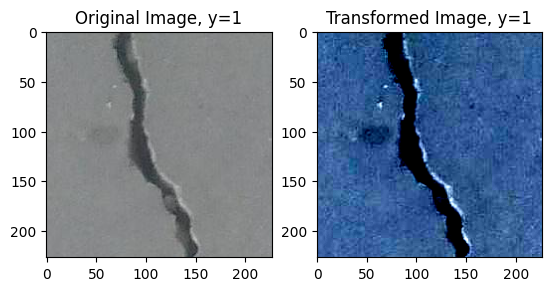

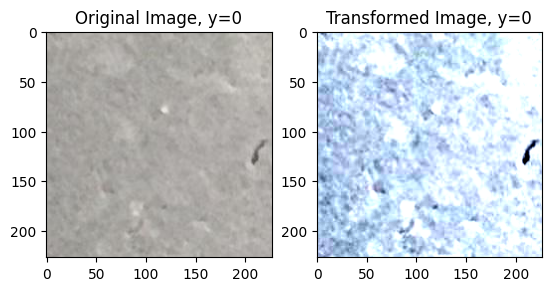

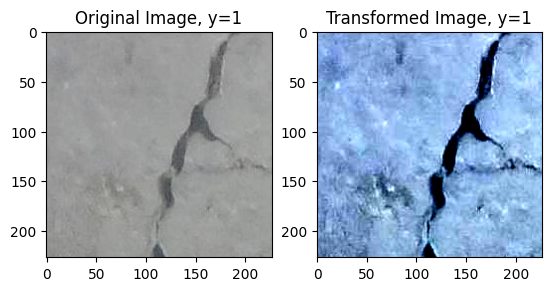

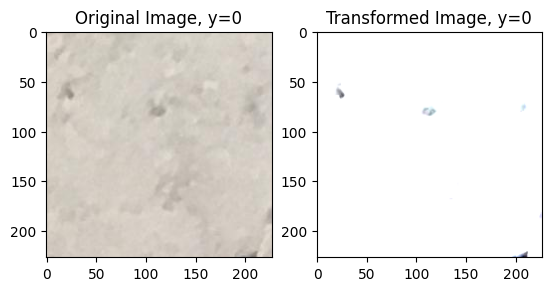

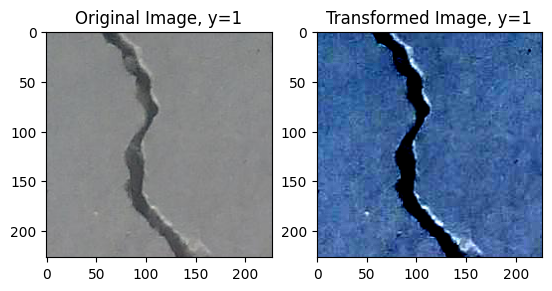

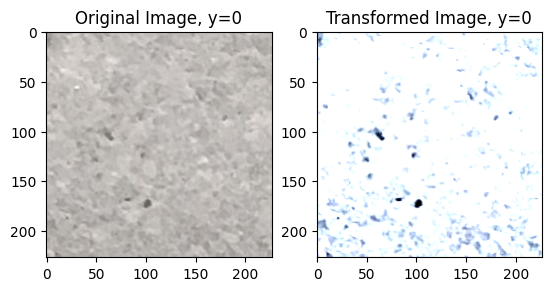

In [11]:
#visualization of 5 image samples
for sample in range(6):
  y=train_dataset[sample][1]
  y_orig=train_dataset_orig[sample][1]
  plt.subplot(1, 2, 1)
  plt.imshow(train_dataset_orig[sample][0])
  plt.title("Original Image, y={}".format(y_orig))
  plt.subplot(1, 2, 2)
  plt.imshow(train_dataset[sample][0].permute(1, 2, 0))
  plt.title("Transformed Image, y={}".format(y))
  plt.show()

<h2 id="model_training">Model training</h2>


To train the model, I use the pre-trained resnet18 as features extractor and replace the output layer with a linear model that predicts two classes. The last hidden layer of resnet18 has 512 neurons so the input size of the output layer is also set to 512.

In [12]:
# Loading of pre-trained model resnet18
model=models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


In [13]:
# The parameter don't need to be trained so require grad is set to false.
for param in model.parameters():
        param.requires_grad = False

In [14]:
# the output layer setting
model.fc = nn.Linear(512, 2)

In [15]:
# a view of the model
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
# the loss function
criterion = nn.CrossEntropyLoss()

In [17]:
# data loader objects.
train_loader = torch.utils.data.DataLoader(dataset=train_dataset , batch_size=100)
validation_loader= torch.utils.data.DataLoader(dataset=validation_dataset , batch_size=5000)

In [18]:
#optimizer to minimize loss
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

<!--Empty Space for separating topics-->


The following code runs the training. With a batch size of 100 and a training set of 30'000 images, one epoch (300 iterations) was judged enough to get satisfactory results. 

In [19]:
n_epochs=1
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(validation_dataset)
N_train=len(train_dataset)
start_time = time.time()
#n_epochs

Loss=0
start_time = time.time()
for epoch in range(n_epochs):
    for x, y in train_loader:

        model.train()
        #clear gradient
        optimizer.zero_grad()
        #make a prediction
        z = model(x)
        # calculate loss
        loss = criterion(z,y)
        # calculate gradients of parameters
        loss.backward()
        # update parameters
        optimizer.step()
        #append loss of iteration to the list
        loss_list.append(loss.data)

    correct=0
    correct_list=[]
    y_predicted = torch.zeros([N_test]).type(torch.LongTensor)
    i=1
    #perform a prediction on the validation  data
    for x_test, y_test in validation_loader:
        # set model to eval
        model.eval()
        #perform a prediction
        z = model(x_test)
        #make a prediction
        _,yhat = torch.max(z.data,1)
        yhat_size=yhat.size(0)
        index_one = i*yhat_size-yhat_size
        index_two = i*yhat_size
        y_predicted[index_one:index_two]=yhat
        i+=1
        #count the number of correct predictions
        correct +=(yhat==y_test).sum().item()
        y_match=(yhat==y_test).tolist()
        correct_list.extend(y_match)


    accuracy=correct/N_test
    accuracy_list.append(accuracy)



In [20]:
#save the model
torch.save(model.state_dict(), 'model_concrete_cracks.pt')

The following accuracy is based on validation data only. This is a proof of concept so the focus is on how the AI is performing on out-of-sample data. With 98% of accuracy, the results are encouraging enough to consider machine vision as a viable solution.

In [21]:
#view of accuracy
accuracy

0.9868

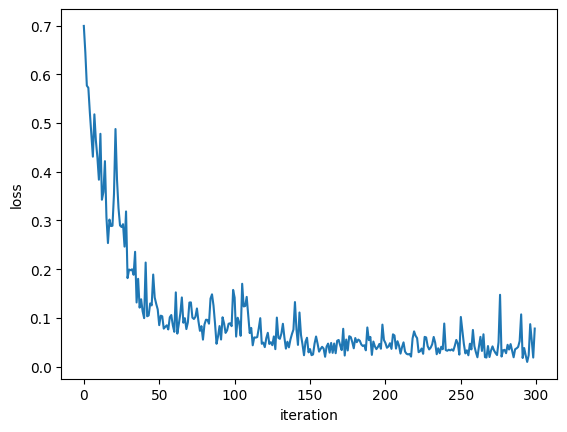

In [22]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()


<h2 id="model_validation">Misclassified data check</h2>

The following images give a preview of the AI limitations. Those are the example of images that are not classified well.This may be due to lack of enough images with this type of cracks.  

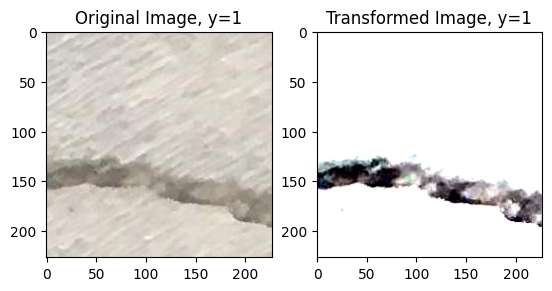

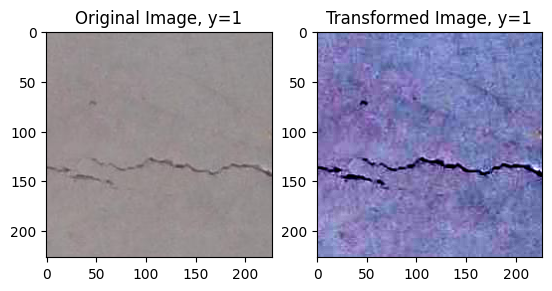

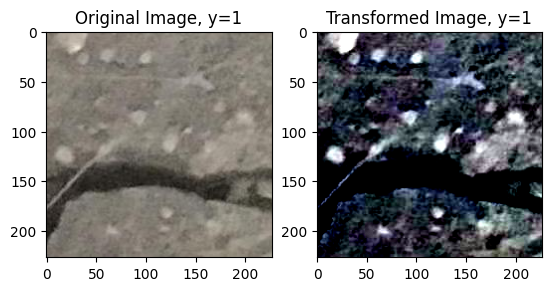

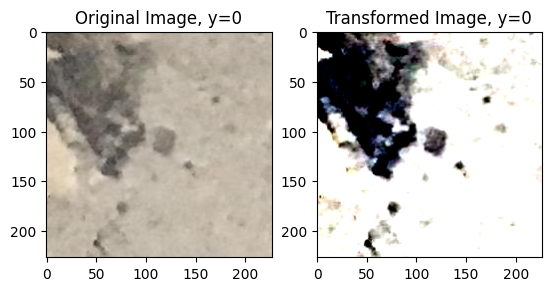

In [23]:
misclassified_indexes = [i for i ,e in enumerate(correct_list) if e == False]
first_four=misclassified_indexes[0:4]

for sample in first_four:
  y=validation_dataset[sample][1]
  y_orig=validation_dataset_orig[sample][1]
  plt.subplot(1, 2, 1)
  plt.imshow(validation_dataset_orig[sample][0])
  plt.title("Original Image, y={}".format(y_orig))
  plt.subplot(1, 2, 2)
  plt.imshow(validation_dataset[sample][0].permute(1, 2, 0))
  plt.title("Transformed Image, y={}".format(y))
  plt.show()

## Conclusion

This project is done to demonstrate the viability of using machine vision as solution to detect cracks in buildings, and the level of accuracy seen here showcases that. 


Author: ornelie Manzambi